In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [114]:
df = pd.read_csv(r'raw\fichajes_news.csv', sep=";")
df.head()

,title,date,content
0,El Real Madrid lo tiene claro: negativa al AC ...,01/08,El Real Madrid ha rechazado un acercamiento po...
1,La Atalanta estudia moverse por una pieza de l...,01/08,Gian Piero Gasperini confía en potenciar toda...
2,La Juventus estudia un fichaje de 20 M€,01/08,Decidida a mejorar las prestaciones de su ataq...
3,Osasuna confirma la venta de David García,01/08,Se venía apuntando a esta posibilidad desde h...
4,El Atlético busca la fórmula para fichar a Al...,01/08,Aunque Alexander Sörloth ya ha dado el sí qui...


In [115]:
player = "morata"

# df_player_content = df[df['content'].str.contains(player)]
# df_player_title = df[df['title'].str.contains(player)]
# ver noticias que mencionen al jugador o tengan una palabra parecida a su nombre
df_player_content = df[df['content'].str.contains(player, case=False)]
df_player_title = df[df['title'].str.contains(player, case=False)]



df_player = pd.concat([df_player_content, df_player_title])
df_player.drop_duplicates(inplace=True)

df_player

,title,date,content
99,"Al descubierto, el precio que abonará el Atlét...",30/07,El Atlético de Madrid ha dado un paso al frent...
136,Atlético de Madrid | Alexander Sörloth toma im...,29/07,El Atlético de Madrid va a ser uno de los anim...
143,El Atlético de Madrid puede pescar en río revu...,29/07,Si el Paris Saint-Germain consigue hacerse con...
194,Atlético de Madrid | Los tres grandes candidat...,28/07,Una vez que ha pinchado en hueso por el Pichic...
204,La pauta a seguir por el AC Milan en este mercado,28/07,Tras dar la bienvenida a un Álvaro Morata que...
...,...,...,...
15562,"Atlético de Madrid | Álvaro Morata, un inicio ...",05/10,Álvaro Morata ha comenzado la temporada como u...
15585,Liga de Campeones | Álvaro Morata ilumina a un...,04/10,Los colchoneros han sufrido mucho esta tarde a...
15593,Las alineaciones del Atlético de Madrid - Feye...,04/10,\r\nAtlético de Madrid \r\nFeyenoord Nueva ...
845,El mercado en directo: Cambio de aires para Mo...,15/07,Fue uno de los verdugos del FC Barcelona hace...


In [116]:
def agregar_año(row):
    try:
        # Intentar convertir la fecha con el formato correcto, agregando el año apropiado
        fecha = pd.to_datetime(row['date'], format='%d/%m', errors='coerce')
        
        # Verificar si la fecha es válida (no es NaT)
        if pd.isna(fecha):
            return None  # Puedes decidir cómo manejar estas fechas no válidas
        
        # Lógica para asignar el año (ajusta según tus criterios)
        if fecha.month in range(10, 12+1):  
            return pd.to_datetime(row['date'] + '/2023', format='%d/%m/%Y', errors='coerce')
        else:  # De lo contrario, asignar 2024
            return pd.to_datetime(row['date'] + '/2024', format='%d/%m/%Y', errors='coerce')
    
    except Exception as e:
        print(f"Error procesando la fila {row.name}: {e}")
        return None

In [117]:
df_player['fecha_completa'] = df_player.apply(agregar_año, axis=1)
df_player

,title,date,content,fecha_completa
99,"Al descubierto, el precio que abonará el Atlét...",30/07,El Atlético de Madrid ha dado un paso al frent...,2024-07-30
136,Atlético de Madrid | Alexander Sörloth toma im...,29/07,El Atlético de Madrid va a ser uno de los anim...,2024-07-29
143,El Atlético de Madrid puede pescar en río revu...,29/07,Si el Paris Saint-Germain consigue hacerse con...,2024-07-29
194,Atlético de Madrid | Los tres grandes candidat...,28/07,Una vez que ha pinchado en hueso por el Pichic...,2024-07-28
204,La pauta a seguir por el AC Milan en este mercado,28/07,Tras dar la bienvenida a un Álvaro Morata que...,2024-07-28
...,...,...,...,...
15562,"Atlético de Madrid | Álvaro Morata, un inicio ...",05/10,Álvaro Morata ha comenzado la temporada como u...,2023-10-05
15585,Liga de Campeones | Álvaro Morata ilumina a un...,04/10,Los colchoneros han sufrido mucho esta tarde a...,2023-10-04
15593,Las alineaciones del Atlético de Madrid - Feye...,04/10,\r\nAtlético de Madrid \r\nFeyenoord Nueva ...,2023-10-04
845,El mercado en directo: Cambio de aires para Mo...,15/07,Fue uno de los verdugos del FC Barcelona hace...,2024-07-15


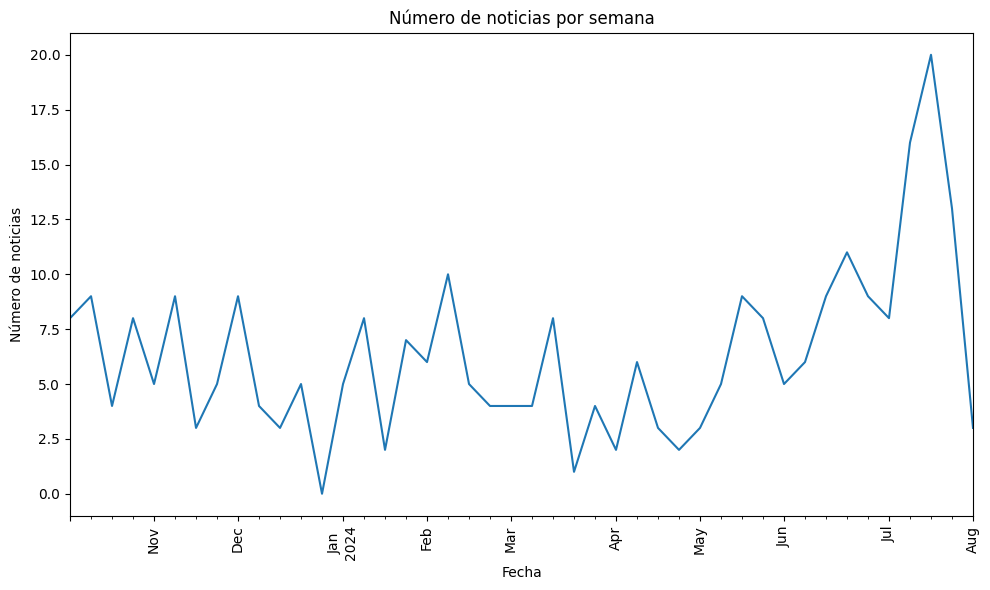

In [118]:
# Filtrar filas que no tengan fechas válidas
df_filtrado = df_player[df_player['fecha_completa'].notna()]

# 3. Contar cuántas noticias hay por día
noticias_por_dia = df_filtrado['fecha_completa'].value_counts().sort_index()



# 4. Crear un rango completo de fechas desde el 1 de enero de 2023 hasta el último día de noticias
fecha_inicio = pd.to_datetime('2023-10-04')
fecha_fin = pd.to_datetime('2024-08-01')  # Última fecha posible
rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin)

# 5. Crear un DataFrame con todas las fechas posibles y fusionarlo con el conteo de noticias
noticias_completas = pd.DataFrame(rango_fechas, columns=['fecha_completa']).set_index('fecha_completa')
noticias_completas['conteo'] = noticias_por_dia

# 6. Rellenar los días faltantes con 0
noticias_completas['conteo'] = noticias_completas['conteo'].fillna(0)

noticias_por_semana = noticias_completas['conteo'].resample('W').sum()



# 4. Graficar el resultado
plt.figure(figsize=(10,6))
noticias_por_semana.plot(kind='line')  # Puedes usar 'bar' si prefieres un gráfico de barras
plt.title('Número de noticias por semana')
plt.xlabel('Fecha')
plt.ylabel('Número de noticias')
plt.xticks(rotation=90)  # Para rotar las etiquetas de las fechas si es necesario
plt.tight_layout()  # Para ajustar el gráfico y que las etiquetas no se corten
plt.show()